In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Bio.PDB import PDBParser
import os

import sys
sys.path.append('/Users/mads/Documents/Python/kermut/')
from src import BLAT_ECOLX_WT, ALPHABET
from src.experiments.investigate_correlations import show_example, load_protein_mpnn_outputs
import pickle


In [3]:
# Compare KLD with Wasserstein distance
# from scipy.stats import wasserstein_distance
# from scipy.special import kl_div
# from scipy.stats import entropy

In [15]:
def compare_sites():
    wd = os.getcwd()
    dataset = "BLAT_ECOLX"
    # Set paths
    data_path = Path(wd, "../", "data", "processed", f"{dataset}.tsv")
    surface_path = Path(wd, "../", "data", "processed", f"{dataset}_surface.csv")
    conditional_probs_path = Path(
        wd, "../",
        "data",
        "interim",
        dataset,
        "proteinmpnn",
        "conditional_probs_only",
        f"{dataset}.npz",
    )
    pdb_path = Path(wd, "../", "data", "raw", f"{dataset}", f"{dataset}.pdb")

    # Load assay and surface data
    df_assay = pd.read_csv(data_path, sep="\t")
    df_surface = pd.read_csv(surface_path)
    wt_seq = BLAT_ECOLX_WT

    # Process dataframe
    df_assay["wt_aa"] = df_assay["mut2wt"].str[0]
    df_assay["aa"] = df_assay["mut2wt"].str[-1]

    # Load PDB file using BioPython
    parser = PDBParser()
    structure = parser.get_structure(dataset, pdb_path)
    model = structure[0]
    chain = model["A"] # ???

    coords = np.array(
        [atom.get_coord() for atom in chain.get_atoms() if atom.get_name() == "CA"]
    )
    df_coords = pd.DataFrame(coords, columns=["x", "y", "z"])
    df_coords["pos"] = df_coords.index + 1

    # Compute pairwise distances
    distance_matrix = np.zeros((coords.shape[0], coords.shape[0]))
    for i in range(coords.shape[0]):
        for j in range(coords.shape[0]):
            distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])

    # Load and process conditional probabilities
    p_mean = load_protein_mpnn_outputs(conditional_probs_path)

    # Compute entropy of each position
    entropy = np.zeros(p_mean.shape[0])
    for i in range(p_mean.shape[0]):
        entropy[i] = -np.sum(p_mean[i] * np.log(p_mean[i]))

    # Get indices of distance_matrix where value < 5 and > 0
    idx_i, idx_j = np.where(distance_matrix < 5)
    idx_i, idx_j = idx_i[idx_i != idx_j], idx_j[idx_i != idx_j]

    # For all pairs, compute KL divergence and Wasserstein distance
    kl_divergence = np.zeros(idx_i.shape[0])
    kl_divergence_reverse = np.zeros(idx_i.shape[0])
    wasserstein_distance = np.zeros(idx_i.shape[0])
    JSD = np.zeros(idx_i.shape[0])
    hellinger_distance = np.zeros(idx_i.shape[0])
    
    check_pairs = set()
    saved_pairs = []
    for i in range(idx_i.shape[0]):
        if ((idx_i[i], idx_j[i]) in check_pairs) or ((idx_j[i], idx_i[i]) in check_pairs) or (idx_i[i] == idx_j[i]):
            continue
        kl_divergence[i] = np.sum(
            p_mean[idx_i[i]] * np.log(p_mean[idx_i[i]] / p_mean[idx_j[i]])
        )
        kl_divergence_reverse[i] = np.sum(
            p_mean[idx_j[i]] * np.log(p_mean[idx_j[i]] / p_mean[idx_i[i]])
        )
        wasserstein_distance[i] = 1-np.min(p_mean[[idx_i[i], idx_j[i]]], axis=0).sum()
        JSD[i] = 1/2 * np.sum(p_mean[idx_i[i]] * (np.log(p_mean[idx_i[i]]) - np.log(p_mean[[idx_i[i],idx_j[i]]].mean(axis=0)))) + 1/2 * np.sum(p_mean[idx_j[i]] * (np.log(p_mean[idx_j[i]]) - np.log(p_mean[[idx_i[i],idx_j[i]]].mean(axis=0))))
        hellinger_distance[i] = np.sqrt( np.sum( (np.sqrt(p_mean[idx_i[i]]) - np.sqrt(p_mean[idx_j[i]]))**2 )/2 )
        check_pairs.add((idx_i[i], idx_j[i]))
        saved_pairs.append(i)
    
    # Collect in DataFrame
    wt_seq_arr = np.array(list(wt_seq))
    df_kl = pd.DataFrame(
        {
            "pos_i": idx_i + 1,
            "pos_j": idx_j + 1,
            "kl_divergence": kl_divergence,
            "kl_divergence_reverse": kl_divergence_reverse,
            "kl_divergence_sum": kl_divergence+kl_divergence_reverse,
            "wasserstein_distance": wasserstein_distance,
            "JSD": JSD,
            "hellinger_distance": hellinger_distance,
            "entropy_i": entropy[idx_i],
            "entropy_j": entropy[idx_j],
            "distance": distance_matrix[idx_i, idx_j],
            "aa_i": wt_seq_arr[idx_i],
            "aa_j": wt_seq_arr[idx_j],
        }
    )
    
    df_kl = df_kl[df_kl.index.isin(saved_pairs)]
    
    # Filter out positions with no assay data
    df_kl = df_kl[
        (df_kl["pos_i"].isin(df_assay["pos"])) & (df_kl["pos_j"].isin(df_assay["pos"]))
    ]
    

    # Filter out positions with high KL divergence and low entropy
    # kl_median = df_kl["kl_divergence"].median()
    # entropy_median = df_kl["entropy_i"].median()
    # df_kl = df_kl[
    #     (df_kl["kl_divergence"] < kl_median)
    #     & (df_kl["entropy_i"] > entropy_median)
    #     & (df_kl["entropy_j"] > entropy_median)
    # ]

    # Sort by KL and inspect top pair
    df_kl = df_kl.sort_values(by="kl_divergence", ascending=True)

    df_kl['hellinger_kernel'] = np.exp(-df_kl.hellinger_distance)
    return p_mean, df_assay, df_kl

In [16]:
p_mean, df_assay, df_kl = compare_sites()

## Combine df with distance metrics with fitness values

In [17]:
substitution_matrix_path = "../data/interim/substitution_matrices.pkl"
substitution_matrix_name = "HENS920102"  # Corresponds to BLOSUM62
with open(substitution_matrix_path, "rb") as f:
    substitution_matrix = pickle.load(f)[substitution_matrix_name]
blosum_order = "ARNDCQEGHILKMFPSTWYV"
substitution_distance = 1 - substitution_matrix
def get_blosum_dist(i, j):
    return substitution_distance[blosum_order.index(i), blosum_order.index(j)]
def get_blosum(i, j):
    return substitution_matrix[blosum_order.index(i), blosum_order.index(j)]

In [18]:
assay_aas = [ALPHABET.index(aa) for aa in df_assay.aa.values]
df_assay['aa_probability'] = p_mean[df_assay.pos.values-1, assay_aas]

In [19]:
df_dist_and_fitness = pd.merge(how='outer', left=df_kl, right=df_assay[df_assay.pos.isin(df_kl.pos_i)], left_on='pos_i', right_on='pos')
df_dist_and_fitness = pd.merge(how='outer', left=df_dist_and_fitness, right=df_assay[df_assay.pos.isin(df_kl.pos_j)], left_on='pos_j', right_on='pos', suffixes=('_assay_i', '_assay_j'))

print("Chech that positions are correctly matched:", (df_dist_and_fitness.pos_assay_i == df_dist_and_fitness.pos_i).all() &  (df_dist_and_fitness.pos_assay_j == df_dist_and_fitness.pos_j).all() )
del df_dist_and_fitness['pos_assay_i']
del df_dist_and_fitness['pos_assay_j']
del df_dist_and_fitness['mut2wt_assay_i']
del df_dist_and_fitness['mut2wt_assay_j']
del df_dist_and_fitness['wt_aa_assay_i']
del df_dist_and_fitness['wt_aa_assay_j']
del df_dist_and_fitness['kl_divergence']
del df_dist_and_fitness['kl_divergence_reverse']

df_dist_and_fitness['fitness_diff'] = df_dist_and_fitness.delta_fitness_assay_i - df_dist_and_fitness.delta_fitness_assay_j
df_dist_and_fitness['abs_fitness_diff'] = df_dist_and_fitness['fitness_diff'].abs()

Chech that positions are correctly matched: True


In [20]:
df_dist_and_fitness['blosum_dist'] = df_dist_and_fitness.apply(lambda x: get_blosum_dist(x['aa_assay_i'], x['aa_assay_j']), axis=1)
df_dist_and_fitness['blosum'] = df_dist_and_fitness.apply(lambda x: get_blosum(x['aa_assay_i'], x['aa_assay_j']), axis=1)

## Combine metrics

In [21]:
df_dist_and_fitness['mut_dist'] = (df_dist_and_fitness.wasserstein_distance + df_dist_and_fitness.blosum_dist) * (1 - df_dist_and_fitness.aa_probability_assay_i) * (1 - df_dist_and_fitness.aa_probability_assay_j)

<Axes: xlabel='mut_dist', ylabel='abs_fitness_diff'>

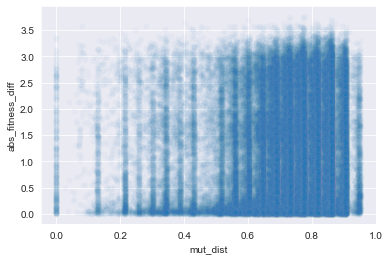

In [ ]:
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist', y='abs_fitness_diff', alpha=0.03)

<Axes: xlabel='mut_dist', ylabel='abs_fitness_diff'>

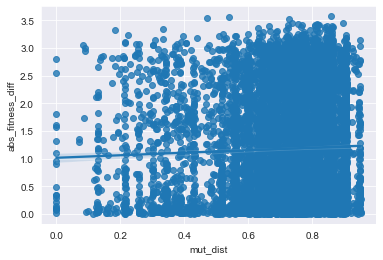

In [1005]:
sns.regplot(data=df_dist_and_fitness.sample(10000), x='mut_dist', y='abs_fitness_diff')

<Axes: xlabel='aa_probability_assay_i', ylabel='aa_probability_assay_j'>

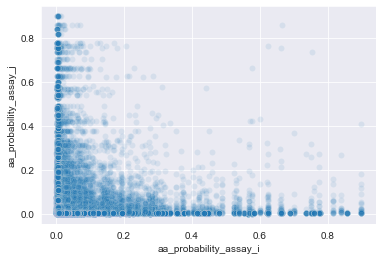

In [1006]:
df_dist_and_fitness.aa_probability_assay_i
sns.scatterplot(data = df_dist_and_fitness, x='aa_probability_assay_i', y='aa_probability_assay_j', alpha=0.1)

## Find transformation for each metric

In [22]:
def generalised_logistic(x, B=1, Q=1):
    return (1+Q*np.exp(-B*x))**(-1)

### Blosum transformation

0.4782608695652174
0.5652173913043478


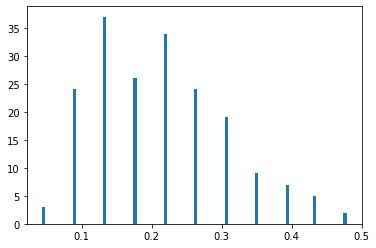

In [23]:
idx_tril = np.tril_indices_from(substitution_matrix, k=-1)
print(substitution_matrix[idx_tril].max())
print(substitution_matrix.diagonal().min())
plt.hist(substitution_matrix[idx_tril], bins=100)
plt.show()

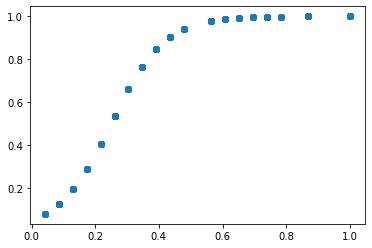

In [24]:
x = df_dist_and_fitness.blosum
y = generalised_logistic(x, B=12, Q=20)
df_dist_and_fitness['blosum_transformed'] = y
plt.scatter(x, y)
plt.show()

### Probability of aa transformation

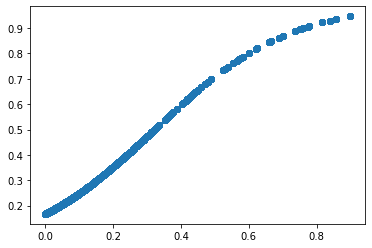

In [27]:
x = df_dist_and_fitness.aa_probability_assay_i
y = generalised_logistic(x, B=3, Q=0.001) # B=15, Q=5
df_dist_and_fitness['aa_p_i_transformed'] = y
x = df_dist_and_fitness.aa_probability_assay_j
y = generalised_logistic(x, B=5, Q=5)
df_dist_and_fitness['aa_p_j_transformed'] = y
plt.scatter(x, y)
plt.show()

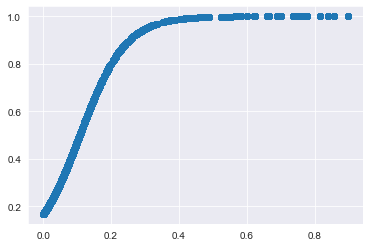

In [1455]:
x = df_dist_and_fitness.aa_probability_assay_i
y = generalised_logistic(x, B=15, Q=5) # B=15, Q=5
df_dist_and_fitness['aa_p_i_transformed'] = y
x = df_dist_and_fitness.aa_probability_assay_j
y = generalised_logistic(x, B=15, Q=5)
df_dist_and_fitness['aa_p_j_transformed'] = y
plt.scatter(x, y)
plt.show()

### Wasserstein transformation (cut at 0.5)

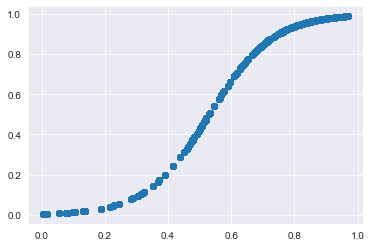

In [1397]:
x = df_dist_and_fitness.wasserstein_distance
y = generalised_logistic(x, B=10, Q=200)
df_dist_and_fitness['wd_transformed'] = 1 - y
plt.scatter(x, y)
plt.show()

<Axes: >

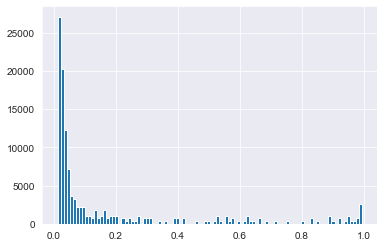

In [1398]:
df_dist_and_fitness['wd_transformed'].hist(bins=100)

In [1013]:
df_kl_subset = df_kl[df_kl.wasserstein_distance.lt(0.5)].sort_values(by='wasserstein_distance', ascending=True)

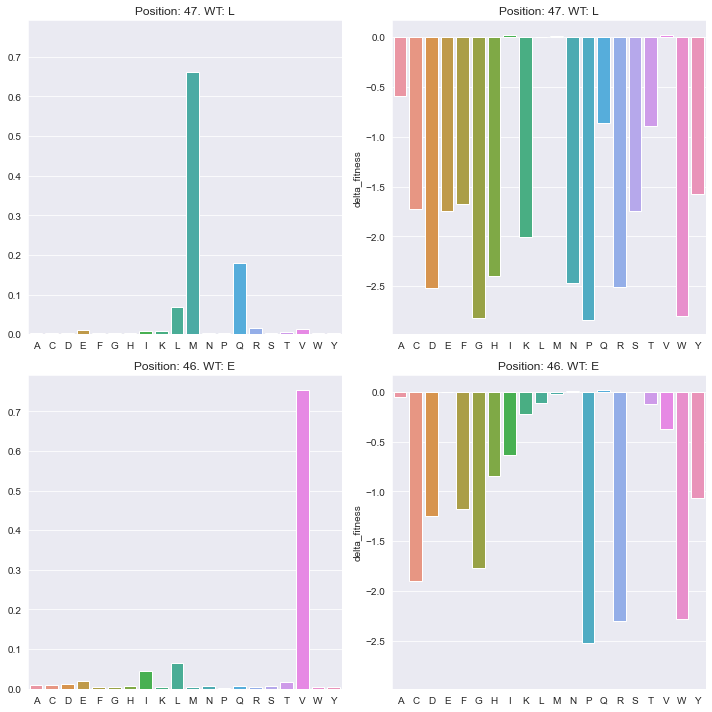

In [1014]:
show_example(23, p_mean, df_assay, df_kl_subset)

### JSD transform

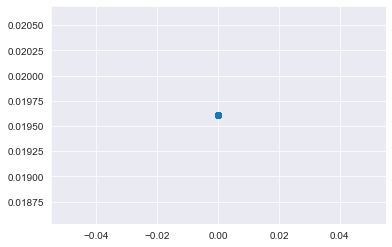

In [1015]:
x = df_dist_and_fitness.JSD
y = generalised_logistic(x, B=15, Q=50)
df_dist_and_fitness['JSD_transformed'] = 1 - y
plt.scatter(x, y)
plt.show()

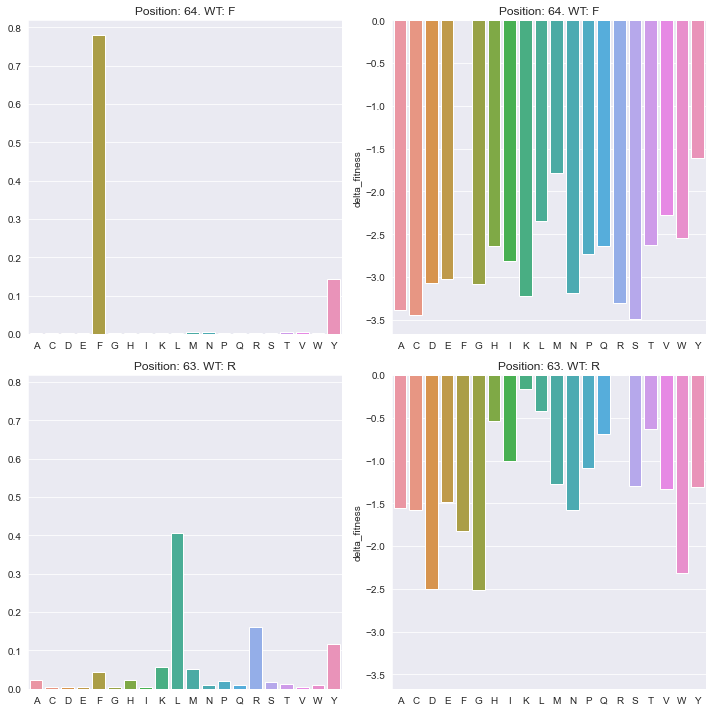

In [1018]:
import random
show_example(random.sample(range(331), 1)[0], p_mean, df_assay, df_kl)

## Metric 2

In [1019]:
df_dist_and_fitness['mut_dist_2'] = df_dist_and_fitness.wd_transformed * df_dist_and_fitness.blosum_transformed * df_dist_and_fitness.aa_p_i_transformed * df_dist_and_fitness.aa_p_j_transformed
df_dist_and_fitness['mut_dist_3'] = df_dist_and_fitness.JSD_transformed * df_dist_and_fitness.blosum_transformed * df_dist_and_fitness.aa_p_i_transformed * df_dist_and_fitness.aa_p_j_transformed

<Axes: >

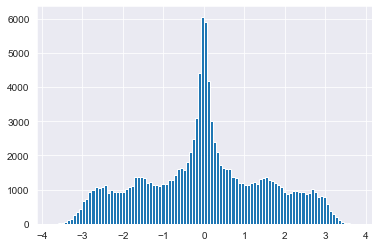

In [1020]:
df_dist_and_fitness.fitness_diff.hist(bins=100)

<Axes: >

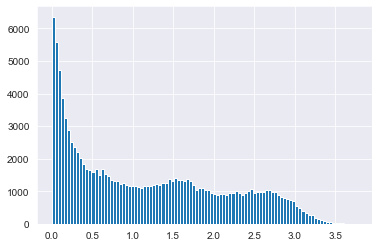

In [1021]:
df_dist_and_fitness.abs_fitness_diff.hist(bins=100)

<Axes: xlabel='mut_dist', ylabel='abs_fitness_diff'>

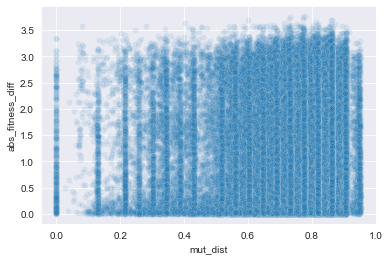

In [1025]:
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist', y='abs_fitness_diff', alpha=0.1)

<Axes: >

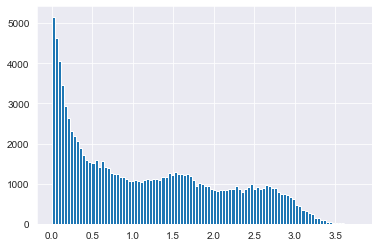

In [1026]:
df_dist_and_fitness[df_dist_and_fitness.mut_dist_2.lt(0.05)].abs_fitness_diff.hist(bins=100)

<Axes: >

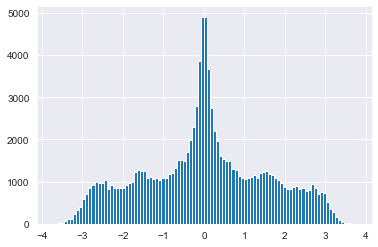

In [1027]:
df_dist_and_fitness[df_dist_and_fitness.mut_dist_2.lt(0.05)].fitness_diff.hist(bins=100)

<Axes: xlabel='mut_dist_2_bins'>

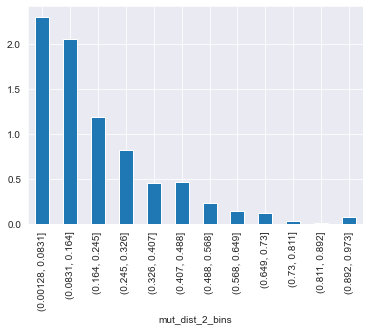

In [1028]:
df_dist_and_fitness['mut_dist_2_bins'] = pd.cut(df_dist_and_fitness.mut_dist_2, bins=12)
df_dist_and_fitness.groupby('mut_dist_2_bins').fitness_diff.var().plot.bar()

<Axes: xlabel='mut_dist_2', ylabel='abs_fitness_diff'>

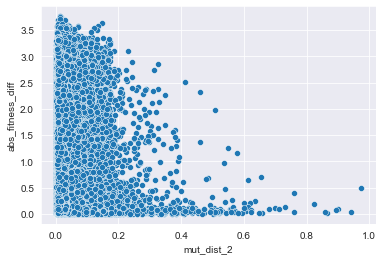

In [1034]:
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist_2', y='abs_fitness_diff', alpha=1)

<Axes: xlabel='mut_dist_2', ylabel='abs_fitness_diff'>

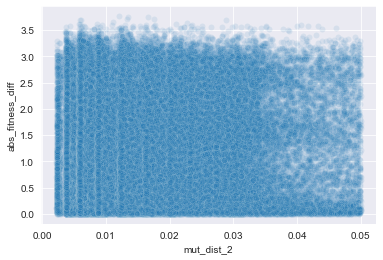

In [1035]:
sns.scatterplot(data=df_dist_and_fitness[df_dist_and_fitness.mut_dist_2.lt(0.05)], x='mut_dist_2', y='abs_fitness_diff', alpha=0.1)

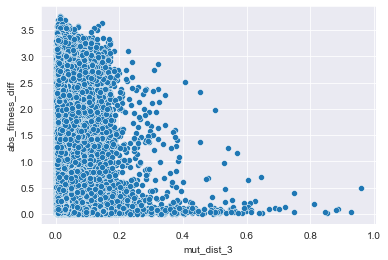

In [1036]:
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist_3', y='abs_fitness_diff', alpha=1)
plt.show()

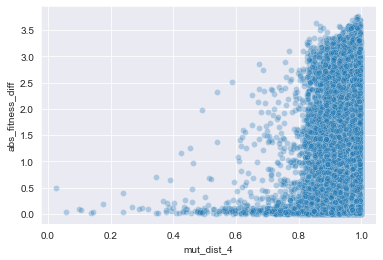

In [1046]:
wd_exp = 1
bl_exp = 1
pi_exp = 1
pj_exp = 1
df_dist_and_fitness['mut_dist_4'] = 1 - df_dist_and_fitness.wd_transformed**wd_exp * df_dist_and_fitness.blosum_transformed**bl_exp * df_dist_and_fitness.aa_p_i_transformed**pi_exp * df_dist_and_fitness.aa_p_j_transformed**pj_exp
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist_4', y='abs_fitness_diff', alpha=0.3)
plt.show()

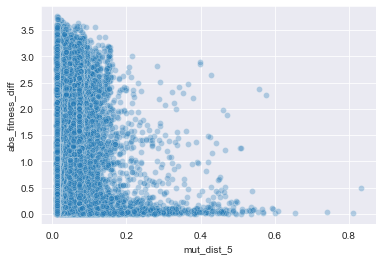

In [1405]:
df_dist_and_fitness['mut_dist_5'] = df_dist_and_fitness.hellinger_kernel * (df_dist_and_fitness.aa_p_i_transformed * df_dist_and_fitness.aa_p_j_transformed)
# df_dist_and_fitness.blosum_transformed
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist_5', y='abs_fitness_diff', alpha=0.3)
plt.show()

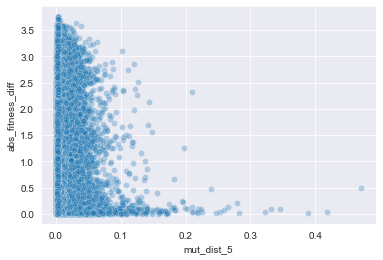

In [1404]:
df_dist_and_fitness['mut_dist_5'] = df_dist_and_fitness.hellinger_kernel * df_dist_and_fitness.aa_p_i_transformed * df_dist_and_fitness.aa_p_j_transformed * df_dist_and_fitness.blosum
# df_dist_and_fitness.blosum_transformed
sns.scatterplot(data=df_dist_and_fitness, x='mut_dist_5', y='abs_fitness_diff', alpha=0.3)
plt.show()

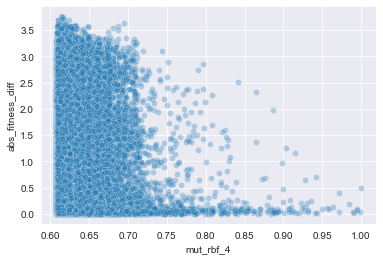

In [1048]:
wd_exp = 1
bl_exp = 1
pi_exp = 1
pj_exp = 1
df_dist_and_fitness['mut_dist_4'] = 1 - df_dist_and_fitness.wd_transformed**wd_exp * df_dist_and_fitness.blosum_transformed**bl_exp * df_dist_and_fitness.aa_p_i_transformed**pi_exp * df_dist_and_fitness.aa_p_j_transformed**pj_exp
df_dist_and_fitness['mut_rbf_4'] = np.exp(-df_dist_and_fitness.mut_dist_4**2/2)
sns.scatterplot(data=df_dist_and_fitness, x='mut_rbf_4', y='abs_fitness_diff', alpha=0.b3)
plt.show()

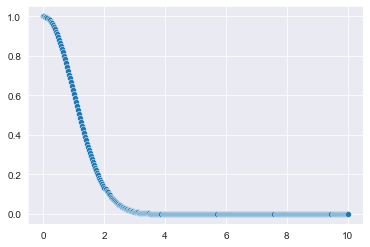

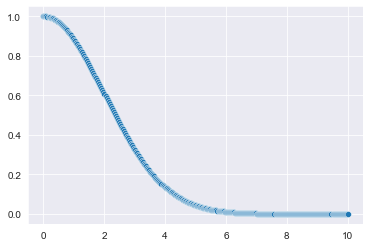

In [1059]:
x = np.linspace(0, 10, 300)
y = np.exp(-x**2/(2*1**2))
sns.scatterplot(x=x, y=y, alpha=1)
plt.show()

x = np.linspace(0, 10, 300)
y = np.exp(-x**2/(2*2**2))
sns.scatterplot(x=x, y=y, alpha=1)
plt.show()

In [1041]:
df_dist_and_fitness.mut_dist_2.gt(0.2).sum()

551

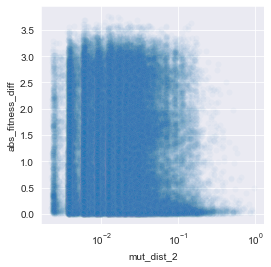

In [1042]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.scatterplot(ax=ax, data=df_dist_and_fitness, x='mut_dist_2', y='abs_fitness_diff', alpha=0.03)
# log transform x axis
ax.set_xscale('log')
plt.show()

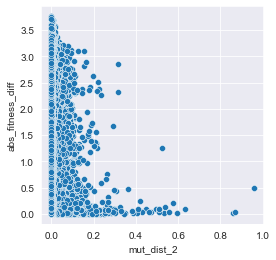

In [747]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
x = df_dist_and_fitness.mut_dist_2
y = df_dist_and_fitness.abs_fitness_diff
sns.scatterplot(ax=ax, x=x, y=y, alpha=1)
# log transform x axis
# ax.set_xscale('log')
plt.show()

<Axes: xlabel='mut_dist_2', ylabel='abs_fitness_diff'>

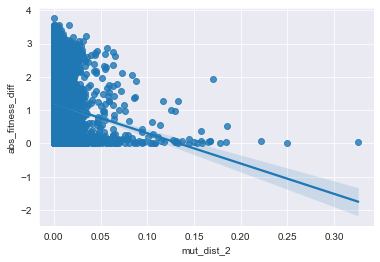

In [748]:
sns.regplot(data=df_dist_and_fitness.sample(10000), x='mut_dist_2', y='abs_fitness_diff')

In [719]:
0.8**4

0.4096000000000001

In [720]:
limit = 0.3

In [721]:
(df_dist_and_fitness.wd_transformed.gt(limit) & df_dist_and_fitness.aa_p_i_transformed.gt(limit) & df_dist_and_fitness.aa_p_j_transformed.gt(limit) & df_dist_and_fitness.blosum_transformed.gt(limit)).sum()

1162

In [722]:
(df_dist_and_fitness.aa_p_i_transformed.gt(limit) & df_dist_and_fitness.aa_p_j_transformed.gt(limit) & df_dist_and_fitness.blosum_transformed.gt(limit)).sum()

2464

In [723]:
(df_dist_and_fitness.aa_p_i_transformed.gt(limit) & df_dist_and_fitness.aa_p_j_transformed.gt(limit)).sum()

3352

In [724]:
df_dist_and_fitness.wd_transformed.gt(limit).sum()

44764

In [725]:
df_dist_and_fitness.blosum_transformed.gt(0.9).sum()

20490

In [726]:
df_dist_and_fitness.aa_p_i_transformed.gt(limit).sum()

28405

In [727]:
df_dist_and_fitness.aa_p_j_transformed.gt(limit).sum()

28405

In [728]:
(df_dist_and_fitness.aa_p_i_transformed.gt(limit) & df_dist_and_fitness.aa_p_j_transformed.gt(limit)).sum()

3352

## Different distance meassures

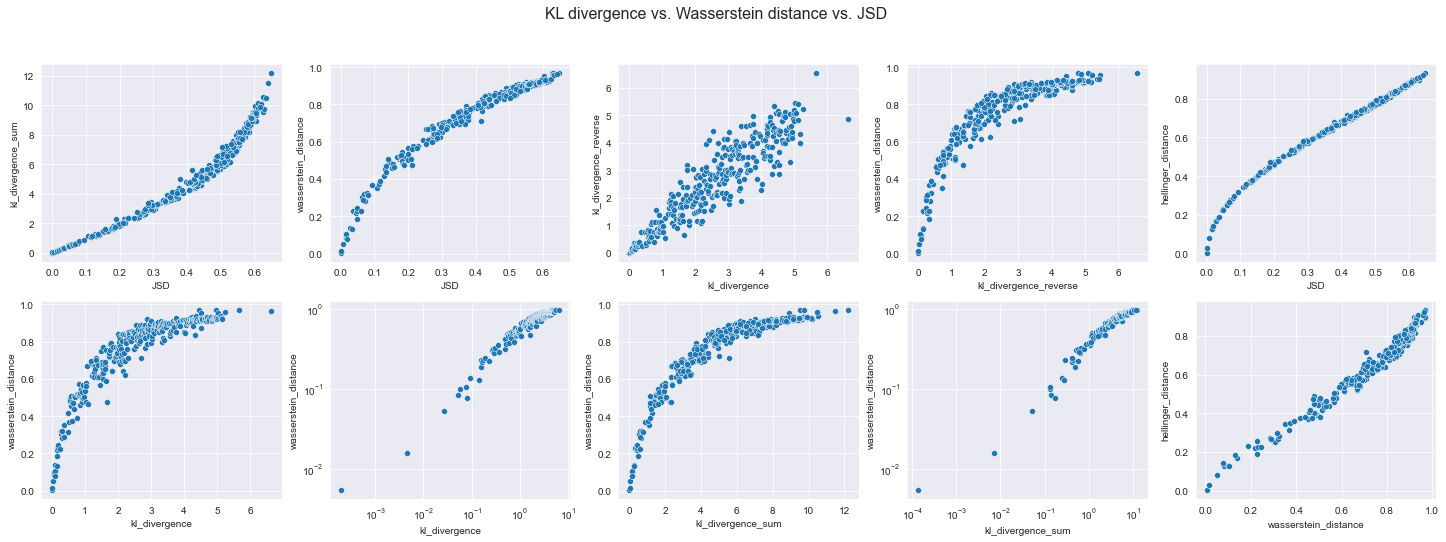

In [1370]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 8))
sns.scatterplot(ax=ax[0,0], data=df_kl, x="JSD", y="kl_divergence_sum")
sns.scatterplot(ax=ax[0,1], data=df_kl, x="JSD", y="wasserstein_distance")

sns.scatterplot(ax=ax[0,2], data=df_kl, x="kl_divergence", y="kl_divergence_reverse")
sns.scatterplot(ax=ax[0,3], data=df_kl, x="kl_divergence_reverse", y="wasserstein_distance")

sns.scatterplot(ax=ax[1,0], data=df_kl, x="kl_divergence", y="wasserstein_distance")
sns.scatterplot(ax=ax[1,1], data=df_kl, x="kl_divergence", y="wasserstein_distance")
ax[1,1].set(xscale="log", yscale="log")

sns.scatterplot(ax=ax[1,2], data=df_kl, x="kl_divergence_sum", y="wasserstein_distance")
sns.scatterplot(ax=ax[1,3], data=df_kl, x="kl_divergence_sum", y="wasserstein_distance")
ax[1,3].set(xscale="log", yscale="log")

sns.scatterplot(ax=ax[0,4], data=df_kl, x="JSD", y="hellinger_distance")
sns.scatterplot(ax=ax[1,4], data=df_kl, x="wasserstein_distance", y="hellinger_distance")

fig.suptitle("KL divergence vs. Wasserstein distance vs. JSD", fontsize=16)
plt.show()


In [1333]:
df_kl.hellinger_kernel.sum()

0.0

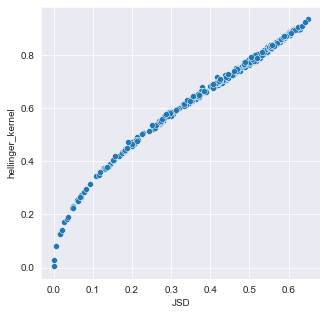

In [1364]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
sns.scatterplot(ax=ax, data=df_kl, x="JSD", y="hellinger_kernel")
plt.show()